In [ ]:
!pip install torchaudio

     |████████████████████████████████| 7.6MB 16.5MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython import display
from dataclasses import dataclass

import torch
from torch import nn

import torchaudio

import librosa
from matplotlib import pyplot as plt


@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0
        
    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()
        
        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))
    

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """
        
        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
featurizer = MelSpectrogram(MelSpectrogramConfig())

/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import string
import numpy as np
from math import isnan
import random

import os
import glob
from torch.nn.utils.rnn import pad_sequence
from functools import partial
from torch.utils.data import random_split

from tqdm import tqdm_notebook
from torch.optim import Adam

In [ ]:
def set_seed(n):
    torch.backends.cudnn.deterministic=True
    torch.manual_seed = n
    random.seed(n)
    np.random.seed(n)

In [ ]:
class LJ_speech(Dataset):

    def __init__(self, wav_ids, root_dir, crop=15000):
        self.wav_ids = wav_ids
        self.root_dir = root_dir
        self.crop=crop

    def __len__(self):
        return len(self.wav_ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        wav_name = os.path.join(self.root_dir,
                                self.wav_ids[idx])
        wav, _ = torchaudio.load(wav_name)
        wav=wav[0]
        start = np.random.randint(low=0, high = len(wav) - self.crop - 1)
        sample = wav[start : start+self.crop]
        return sample

In [ ]:
def my_collate(data, mu_law, featurizer):
    max_len = 0
    
    mels = []
    wav_batch = torch.stack(data)
    for i in range(len(wav_batch)):
      mels.append(featurizer(wav_batch[i]))
      wav_batch[i] = mu_law(wav_batch[i])
    
    mels_batch = torch.stack(mels)
    return mels_batch, wav_batch

In [ ]:
class Block(nn.Module):
    
    def __init__(self, n_mels, dilation, r, s=240):
        super(Block, self).__init__()
        self.conditional = nn.Conv1d(n_mels, 2*r, kernel_size=1)
        self.dilated = nn.Conv1d(r, 2*r, kernel_size=2, dilation=dilation)
        self.left_pad = nn.ConstantPad1d((dilation, 0), 0)

        self.t = nn.Tanh()
        self.s = nn.Sigmoid()
        self.skip = nn.Conv1d(r, s, kernel_size=1)
        self.residual = nn.Conv1d(r, r, kernel_size=1)
        self.r=r

    def forward(self, mel, wav):
        
        wav_dilated = self.left_pad(wav)
        mel = self.conditional(mel)
        wav_dilated = self.dilated(wav_dilated)
        xt = mel[:, :self.r] + wav_dilated[:, :self.r] #??
        xs = mel[:, self.r:] + wav_dilated[:, self.r:]
        xt = self.t(xt)
        xs = self.s(xs)
        x = xt * xs
        return self.skip(x), self.residual(x)+wav


In [ ]:

class WaveNet(nn.Module):
    
    def __init__(self, device, hop_len=256, upsample_kernel=512, n_mels=80, caus_ks=256, r=120, s=240, a=256, n_blocks=16):
        super(WaveNet, self).__init__()
        self.hop_len=hop_len
        self.a=a
        self.upsample = nn.ConvTranspose1d(n_mels, n_mels, kernel_size=upsample_kernel, stride=hop_len, padding=upsample_kernel//2)

        self.left_pad = nn.ConstantPad1d((caus_ks-1, 0), 0)
        self.causal = nn.Conv1d(1, r, kernel_size=caus_ks)

        dilations = [2**i for i in range(8)]
        dilations.extend(dilations)
        self.blocks = nn.ModuleList([Block(n_mels=n_mels, dilation=i, r=r, s=s) for i in dilations])

        self.relu1 = nn.ReLU(True)
        self.out = nn.Conv1d(s, a, kernel_size=1)
        self.relu2 = nn.ReLU(True)
        self.end = nn.Conv1d(a, a, kernel_size=1)
        self.device=device

        print('upsample:', count_parameters(self.upsample))
        print('causal', count_parameters(self.causal))
        print('blocks', count_parameters(self.blocks))
        print('out', count_parameters(self.out))
        print('end', count_parameters(self.end))
    
    def forward(self, mel, wav, UP = True):
        if UP:
          mel = self.upsample(mel)
          mel = mel[:, :, 1:]
          
        wav = self.left_pad(wav).unsqueeze(1)
        wav = self.causal(wav)
        skips = None
        for block in self.blocks:
          skip, wav = block(mel, wav)
          if skips is None:
            skips = skip
          else:
            skips = skips+skip
        res = self.relu1(skips)
        res = self.out(res)
        res = self.relu2(res)
        return self.end(res)

    def inference(self, mel):
        mel = self.upsample(mel)
        res = self.forward(mel[:, :, 0].unsqueeze(2), torch.tensor([[0.0]]).to(self.device), UP=False) #предсказываем первый вав по первому мелу и 0.0
        out = torch.zeros(mel.shape[2]).to(self.device) #создаем тензор длины апнутого мела
        out[0] = torch.argmax(res, dim=1).type(torch.FloatTensor)[0][0] #первый эелемент уже предсказали, остальное в цикле
        pbar = tqdm_notebook(total = mel.shape[2]-1)

        for i in range(1, mel.shape[2]):
          res = self.forward(mel[:, :, 1:i+1], out[:i].unsqueeze(0), UP=False)
          out[i] = torch.argmax(res, dim=1).type(torch.FloatTensor)[0][-1]
          pbar.update(1)
        pbar.close()
        return out

In [ ]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WaveNet(device).to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

upsample: 3276880
causal 30840
blocks 1933440
out 61696
end 65792


In [ ]:
mu_law = torchaudio.transforms.MuLawEncoding(quantization_channels=256)
mu_law_dec = torchaudio.transforms.MuLawDecoding(quantization_channels=256)

In [ ]:
from os import listdir
from os.path import isfile, join

set_seed(42)
CROP=3840

root = '/content/drive/MyDrive/DLA/hw5/LJSpeech-1.1/wavs/'

wav_ids = [f for f in listdir(root) if isfile(join(root, f))]

dataset = LJ_speech(wav_ids, root, crop=CROP)

data_len = len(dataset)
test_len = int(data_len*0.3)
train_len = data_len - test_len

train, val = random_split(dataset, [train_len, test_len])

batch_size= 1
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=partial(my_collate, mu_law=mu_law, featurizer=featurizer))

val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True, collate_fn=partial(my_collate, mu_law=mu_law, featurizer=featurizer))

In [ ]:
batch_size= 1
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=partial(my_collate, mu_law=mu_law, featurizer=featurizer))

val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True, collate_fn=partial(my_collate, mu_law=mu_law, featurizer=featurizer))

In [ ]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 5368648


In [ ]:
for data in train_loader:
    mel, wav = data
    mel = mel.to(device)
    wav = wav.to(device)
    break

In [ ]:

running_loss=0.0
ctr=0
for i in range(121):
    model.train()
    optimizer.zero_grad()
    output = model(mel, wav[:, :-1])
    output = output.transpose(-1, -2)
    loss = criterion(output.view(-1, 256), wav[:, 1:].contiguous().view(-1).type(torch.LongTensor).to(device))
    running_loss += loss.item()
    
    loss.backward()

    optimizer.step()

    ctr+=1
    if i % 20 == 0:
      print(i, running_loss/ctr)
      running_loss=0.0
      ctr=0


0 5.61366081237793
20 4.605811190605164
40 3.57071613073349
60 2.3093676567077637
80 1.0259847566485405
100 0.16184781584888697
120 0.02658768678084016


In [ ]:
model.eval()
with torch.no_grad():
  pred = model.inference(mel)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
decoded_pred = mu_law_dec(pred)
decoded_wav = mu_law_dec(wav[0])

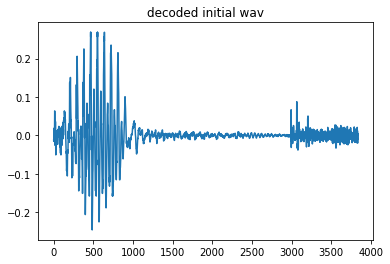

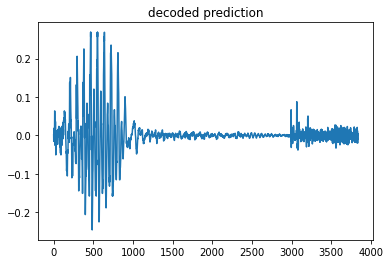

In [ ]:
plt.plot(decoded_wav.cpu())
plt.title('decoded initial wav')
plt.show()

plt.plot(decoded_pred.cpu())
plt.title('decoded prediction')
plt.show()